## Data Load & Characteristics

- Load data and look at its characteristics

### Libraries & Functions


In [1]:
# Libraries
#

import os

import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, zero_one_loss, confusion_matrix
import shap

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns


In [2]:
# Establish valid data file path, for reading and saving eg CSV files
#

import os
data_directory = 'Data_Sources'          # Designated data folder above the current working directory
project_directory = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(project_directory, data_directory)
if not os.path.isdir(DATA_PATH):
    raise Exception(f'Directory not found: {DATA_PATH}')

del data_directory, project_directory

In [3]:
# A simple utility function to obtain and summarise key elements of a given dataframe

def print_file_summary(data_frame):
    # Create a temporary df and ensure no lists remain, so that unique items can be identified for uniqueness
    temp_df = data_frame.copy()
    temp_df = temp_df.map(lambda cell: str(cell) if isinstance(cell, list) else cell)
    
    # Calculate Data Types 
    summary_of_df = pd.DataFrame({'Count': data_frame.count(),
                                 'Missing': data_frame.isnull().sum(), 'Empty': 0,
                                 'Unique': temp_df.nunique(),
                                 'Type': data_frame.dtypes, 
                                 'String': 0, 'Int': 0, 'Float': 0, 'List': 0
                                 })
    summary_of_df['Empty'] = (data_frame == '').sum()
    summary_of_df['String'] = data_frame.map(lambda cell: isinstance(cell, str)).sum()
    summary_of_df['Int'] = data_frame.map(lambda cell: isinstance(cell, int)).sum()
    summary_of_df['Float'] = data_frame.map(lambda cell: isinstance(cell, float)).sum()
    summary_of_df['List'] = data_frame.map(lambda cell: isinstance(cell, list)).sum()

    display(summary_of_df)

### Characteristics


In [4]:
# Load Source CSV files

file_name = 'hotel_reviews.csv'
file_path = os.path.join(DATA_PATH, file_name)
if not os.path.isfile(file_path):
    raise Exception(f'File not found: {file_path}')

hotel_reviews_df = pd.read_csv(file_path)

# Convert categorical values for XGBoost
categorical_columns = ['gender', 'purpose_of_travel','type_of_travel', 'type_of_booking']
for next_col in categorical_columns:
    hotel_reviews_df[next_col] = hotel_reviews_df[next_col].astype('category')

# Tidy Up
del file_name, file_path, categorical_columns, next_col

In [5]:
#| label: csv_file_types
#| tbl-cap: Loaded File Data Types

print_file_summary(hotel_reviews_df)

,Count,Missing,Empty,Unique,Type,String,Int,Float,List
id,103904,0,0,103904,int64,0,103904,0,0
gender,103904,0,0,2,category,103904,0,0,0
age,103904,0,0,75,int64,0,103904,0,0
purpose_of_travel,103904,0,0,5,category,103904,0,0,0
type_of_travel,103904,0,0,2,category,103904,0,0,0
type_of_booking,103904,0,0,3,category,103904,0,0,0
score_wifi,103904,0,0,4,int64,0,103904,0,0
score_transport,103904,0,0,5,int64,0,103904,0,0
score_booking,103904,0,0,5,int64,0,103904,0,0
score_location,103904,0,0,5,int64,0,103904,0,0


In [6]:
#| label: csv_file_summary

print(hotel_reviews_df.head(3))

       id  gender  age purpose_of_travel   type_of_travel type_of_booking  \
0   70172    Male   13          aviation  Personal Travel     Not defined   
1    5047    Male   25           tourism     Group Travel  Group bookings   
2  110028  Female   26           tourism     Group Travel  Group bookings   

   score_wifi  score_transport  score_booking  score_location  \
0           1                3              2               1   
1           1                2              2               2   
2           1                2              2               2   

   score_restaurant  score_staff  score_parking  score_checkin  \
0                 3            2              1              3   
1                 0            0              0              1   
2                 3            2              1              3   

   score_local_sites  score_housekeeping  score_overall  
0                  4                   4              2  
1                  3                   1         

In [7]:
#| label: csv_file_stats
#| tbl-cap: Loaded File Characteristics

#print(hotel_reviews_df.describe())
display(hotel_reviews_df.describe().T.style.format("{:.2f}"))

,count,mean,std,min,25%,50%,75%,max
id,103904.00,64924.21,37463.81,1.00,32533.75,64856.50,97368.25,129880.00
age,103904.00,39.38,15.11,7.00,27.00,40.00,51.00,85.00
score_wifi,103904.00,1.21,0.89,0.00,1.00,1.00,2.00,3.00
score_transport,103904.00,2.43,1.13,0.00,2.00,2.00,3.00,4.00
score_booking,103904.00,2.20,1.01,0.00,2.00,2.00,3.00,4.00
score_location,103904.00,2.33,0.91,0.00,2.00,2.00,3.00,4.00
score_restaurant,103904.00,1.54,0.96,0.00,1.00,1.00,2.00,3.00
score_staff,103904.00,1.14,0.59,0.00,1.00,1.00,2.00,2.00
score_parking,103904.00,0.24,0.43,0.00,0.00,0.00,0.00,1.00
score_checkin,103904.00,2.55,0.94,0.00,2.00,2.00,3.00,4.00


## XGBoost Model Creation & Forecasting


### Initial XGBoost Model Creation

In [8]:
# XGBoost Model Training

# Split the data into features X and target Y which is the customer satisfaction score

X = hotel_reviews_df.drop(columns=['id', 'score_overall'])
y = hotel_reviews_df['score_overall']

# Split the data randomly with 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model & fit to the data
model = xgb.XGBClassifier(enable_categorical=True)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Evaluate The XGBoost Model



              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2142
           1       0.47      0.47      0.47      4826
           2       0.45      0.46      0.45      4745
           3       0.47      0.48      0.48      4589
           4       0.46      0.43      0.44      4479

    accuracy                           0.51     20781
   macro avg       0.56      0.56      0.56     20781
weighted avg       0.51      0.51      0.51     20781

Classification Error: 0.49


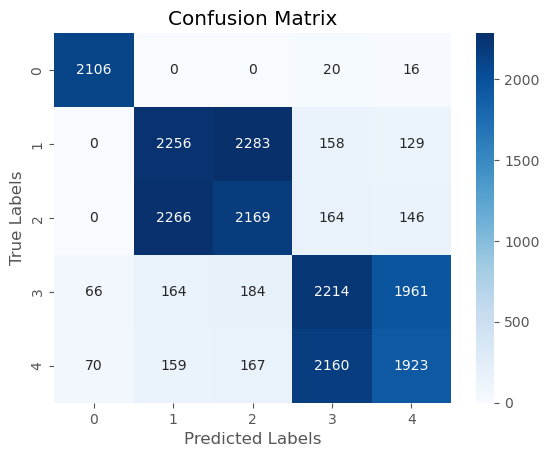

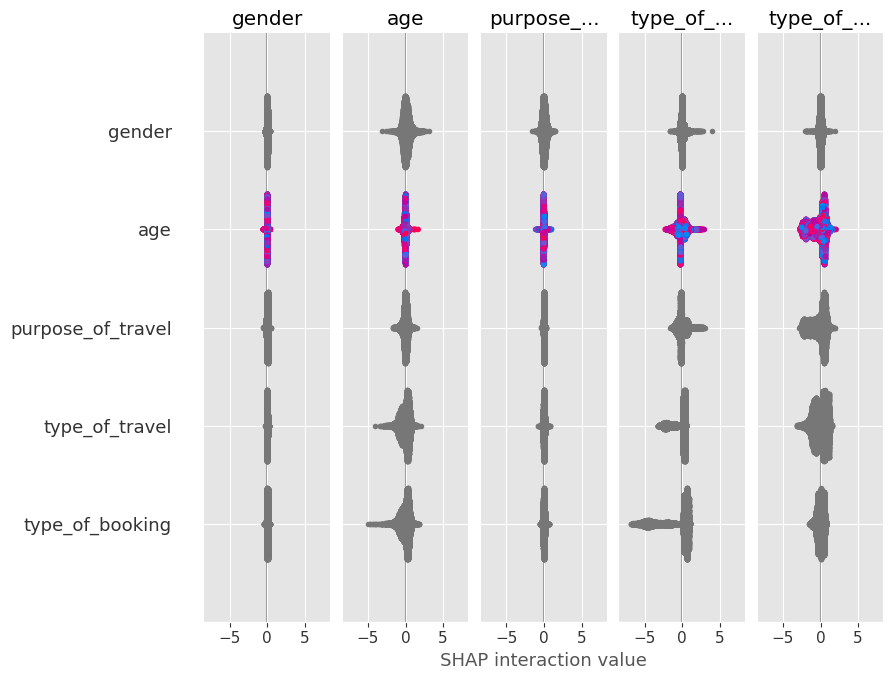

In [9]:
# Model Evaluation

# Predictions
y_predictions = model.predict(X_test)

# Classification report & accuracy score & Classification error
print(classification_report(y_test, y_predictions))
error = zero_one_loss(y_test, y_predictions)
print(f"Classification Error: {error:.2f}")

# Calculate and visualise the confusion matrix
cm = confusion_matrix(y_test, y_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# SHAP Feature importance
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


### XGBoost Model - Features Ranking


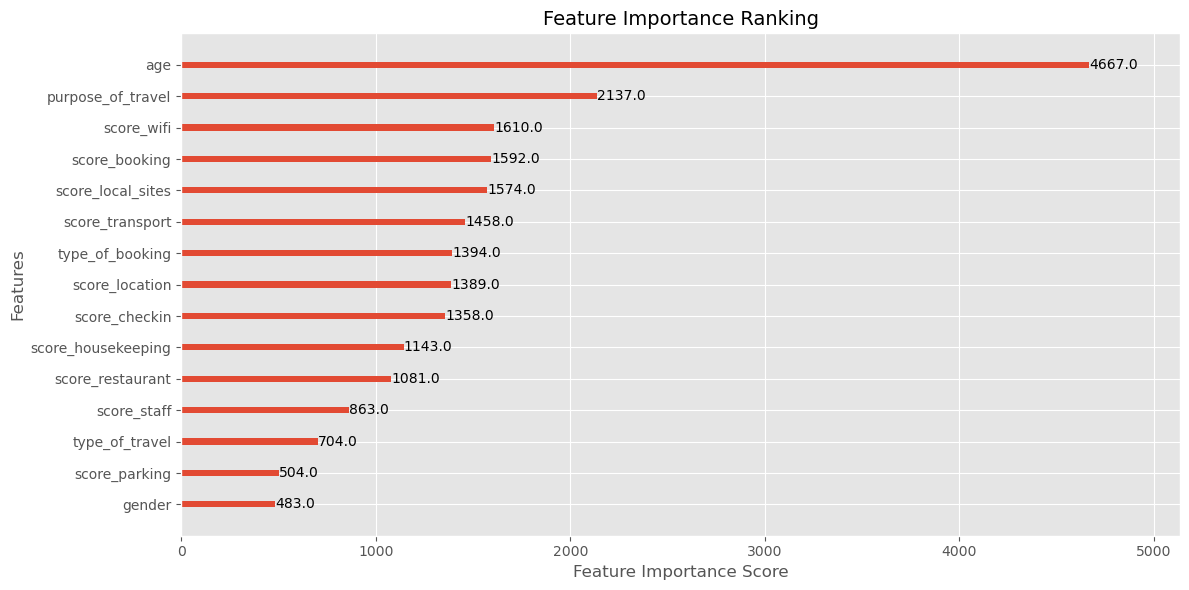

In [10]:
#| label: feature-importance
#| fig-cap: XGBoost Feature Importance Results - All Features

# Identify Current Feature Importance
#

# Plot the features by importance
fig, ax1 = plt.subplots(figsize=(12, 6))
xgb.plot_importance(model, ax=ax1)

ax1.set_title(f'Feature Importance Ranking', fontsize=14)
ax1.set_xlabel('Feature Importance Score', fontsize=12)
ax1.set_ylabel('Features', fontsize=12)

plt.tight_layout()
plt.show()

### XGBoost Model - Features Subset

In [11]:
# XGBoost Model Training - Repeat for Subset of Features

# Drop non-score features

hotel_reviews_sub_df = hotel_reviews_df.drop(columns=['age', 'purpose_of_travel', 
                                                      'type_of_booking', 'type_of_travel', 'gender'])

# Split the data into features X and target Y which is the customer satisfaction score

X = hotel_reviews_sub_df.drop(columns=['id', 'score_overall'])
y = hotel_reviews_sub_df['score_overall']

# Split the data randomly with 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model & fit to the data
model = xgb.XGBClassifier(enable_categorical=True)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2142
           1       0.46      0.44      0.45      4826
           2       0.44      0.49      0.46      4745
           3       0.46      0.44      0.45      4589
           4       0.44      0.41      0.43      4479

    accuracy                           0.50     20781
   macro avg       0.54      0.55      0.55     20781
weighted avg       0.50      0.50      0.50     20781

Classification Error: 0.50


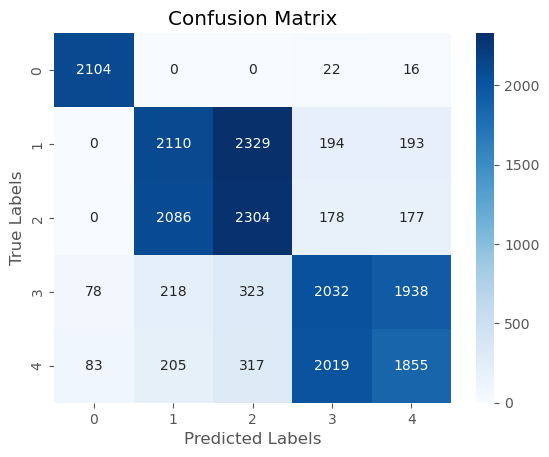

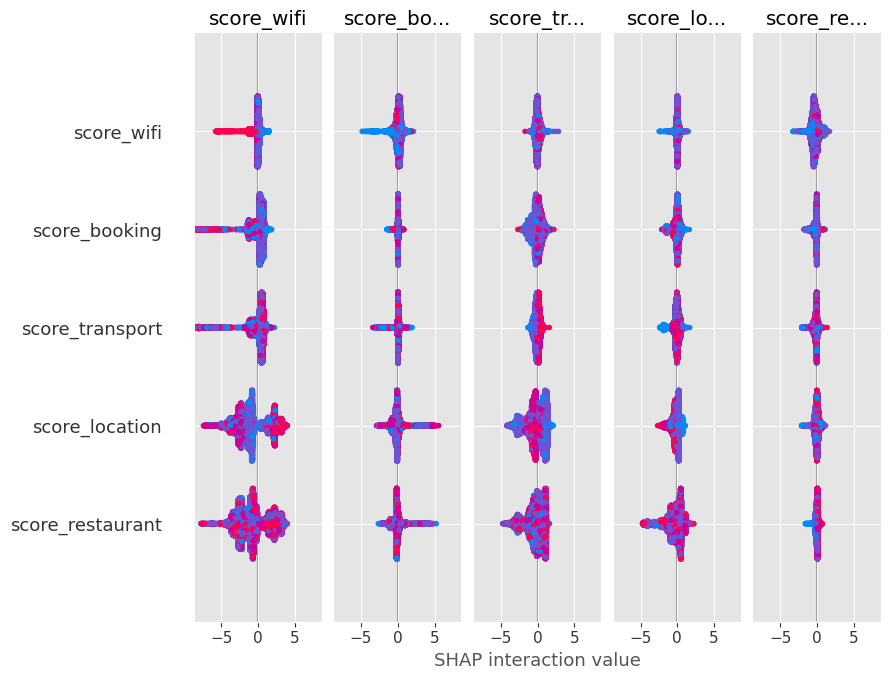

In [12]:
# Model Evaluation

# Predictions
y_predictions = model.predict(X_test)

# Classification report & accuracy score & Classification error
print(classification_report(y_test, y_predictions))
error = zero_one_loss(y_test, y_predictions)
print(f"Classification Error: {error:.2f}")

# Calculate and visualise the confusion matrix
cm = confusion_matrix(y_test, y_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# SHAP Feature importance
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

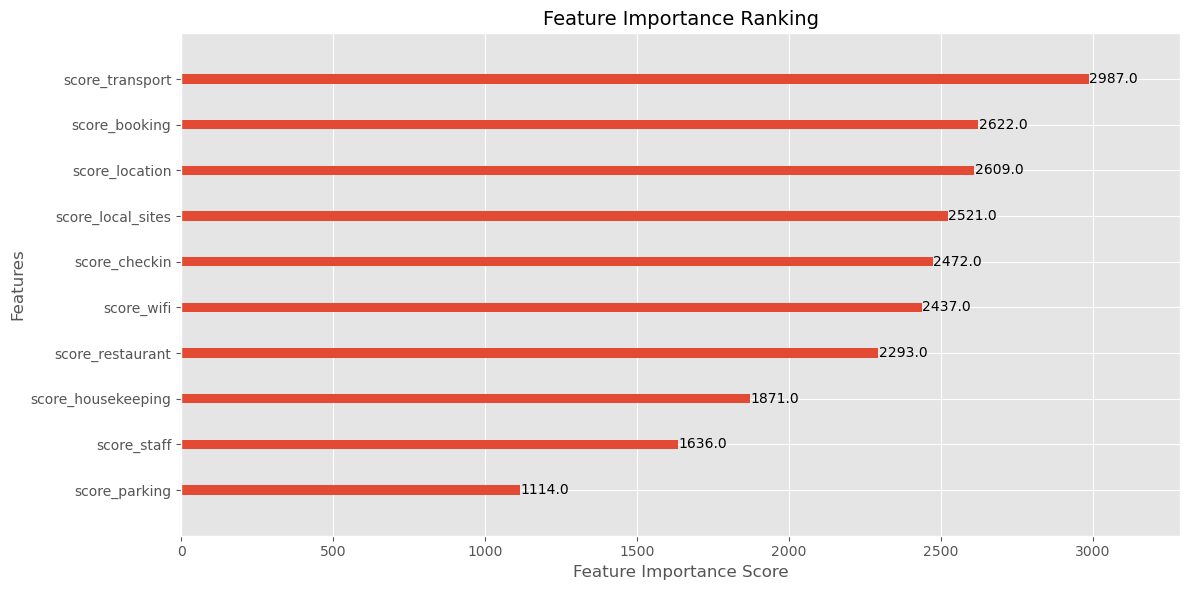

In [13]:
#| label: feature-importance-scores
#| fig-cap: XGBoost Feature Importance Results - Service Features Only

# Identify Current Feature Importance
#

# Plot the features by importance
fig, ax1 = plt.subplots(figsize=(12, 6))
xgb.plot_importance(model, ax=ax1)

ax1.set_title(f'Feature Importance Ranking', fontsize=14)
ax1.set_xlabel('Feature Importance Score', fontsize=12)
ax1.set_ylabel('Features', fontsize=12)

plt.tight_layout()
plt.show()

In [16]:
#| label: feature-table-data
#| tbl-cap: XGBoost Feature Importance & Satisfaction


# Create a table of features with Satisfaction & Importance

# Calculate the average satisfaction score for each feature with a score
score_columns = hotel_reviews_df.columns[hotel_reviews_df.columns.str.startswith('score_')]
filter_columns = hotel_reviews_df[score_columns]
averages = filter_columns.mean() + 1
averages = averages.rename_axis('feature')
averages_df = averages.reset_index()
averages_df.columns = ['feature', 'satisfaction_mean']

# For each feature, add the predicted importance from the XGBoost model
feature_importance = model.get_booster().get_score(importance_type='weight')
feature_importance_df = pd.DataFrame({'feature': feature_importance.keys(), 'importance': feature_importance.values()})

# Create a table of features with the predicted importance and the mean satisfaction rating
features_table = pd.merge(feature_importance_df, averages_df, on='feature', how='inner')
#features_table = pd.merge(feature_importance_df, averages_df, on='feature', how='left')
features_table = features_table.fillna(0.5)

# Scale the importance to 0:100 for plotting purposes
#max_importance = max(features_table['importance'])
max_importance = 4000       # Temporarily set manually
features_table['importance'] = ((features_table['importance']/max_importance)*100).round(0).astype(int)

final_df = features_table.sort_values(by='importance', ascending=False).reset_index(drop=True)

display(final_df)

,feature,importance,satisfaction_mean
0,score_transport,75,3.425912
1,score_booking,66,3.199935
2,score_location,65,3.333192
3,score_local_sites,63,3.818900
4,score_checkin,62,3.552443
5,score_wifi,61,2.209703
6,score_restaurant,57,2.539354
7,score_housekeeping,47,3.569901
8,score_staff,41,2.138532
9,score_parking,28,1.242657


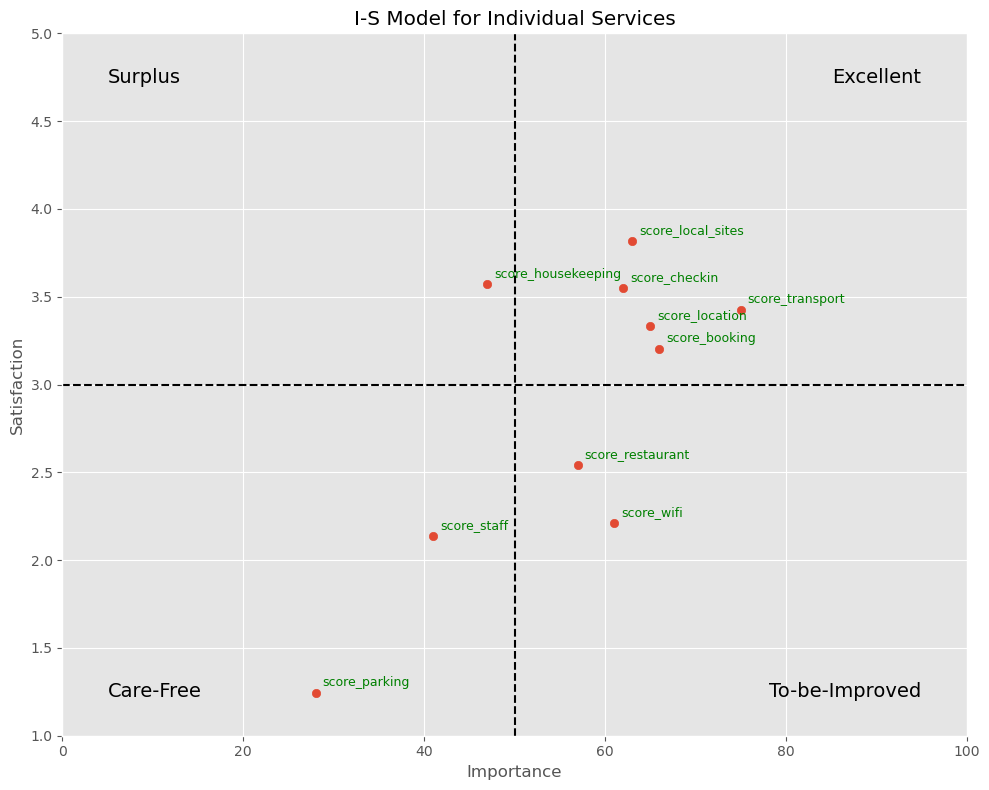

In [15]:
#| label: feature-table
#| fig-cap: Importance-Significance Predictions

# Dat aPoints
x = features_table['importance']
y = features_table['satisfaction_mean']
labels = features_table['feature']

# Create the scatter plot and add labels for each point
plt.figure(figsize=(10, 8))
plt.title('I-S Model for Individual Services')
plt.xlabel('Importance')
plt.ylabel('Satisfaction')

plt.scatter(x, y)
for i, (xi, yi, label) in enumerate(zip(x, y, labels)):
    plt.annotate(label, 
                 (xi, yi),  # Point to annotate
                 xytext=(5, 5),  # Offset of the text
                 textcoords='offset points',
                 fontsize=9,
                 color='green') 

plt.xlim(0,100) 
plt.ylim(1, 5)

# Add Quadrants
plt.text(0.95, 0.95, 'Excellent', ha='right', va='top', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.05, 0.95, 'Surplus', ha='left', va='top', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.05, 0.05, 'Care-Free', ha='left', va='bottom', transform=plt.gca().transAxes, fontsize=14)
plt.text(0.95, 0.05, 'To-be-Improved', ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=14)

plt.axhline(y=3, color='k', linestyle='--')
plt.axvline(x=50, color='k', linestyle='--')

plt.tight_layout()
plt.show()